<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Climate indices
In this tutorial we will plot a map of wind chill over Europe using regional climate reanalysis data (UERRA) of wind speed and temperature. From the WEkEO Jupyterhub we will download this data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S). The tutorial comprises the following steps:

1. [Search and download](#search_download) regional climate reanalysis data (UERRA) of 10m wind speed and 2m temperature.
2. [Read data](#read_data): Once downloaded, we will read and understand the data, including its variables and coordinates.
3. [Calculate wind chill index](#wind_chill): We will calculate the wind chill index from the two parameters of wind speed and temperature, and view a map of average wind chill over Europe.
4. [Calculate wind chill with ERA5](#era5): In order to assess the reliability of the results, repeat the process with ERA5 reanalysis data and compare the results with those derived with UERRA.

<img src='./img/climate_indices.png' align='center' width='100%'></img>

### About

In this tutorial we will plot compute the average wind chill index over Europe for 15 December at 12:00 UTC using the reanalysis dataset ERA5-Land. The wind chill index is a metric in temperature-like units and represents the degree of 'chill' that your skin senses.

The notebooks has four sections. The first section [1 - Data preparation](#data_preparation) is mandatory, as it loads and prepares the dataset for the following parts. Sections 2 to 4 are practical examples of how to compute and analyse climatologies and anomalies on different spatial (global and regional) and temporal (annual, monthly and seasonal) levels.

The notebook has the following outline:

* [1 - Data preparation](#data_preparation)
* [2 - Calculation of the annual global mean surface air temperature anomaly](#global_mean)
* [3 - Calculation of the monthly surface air temperature anomaly in Europe](#monthly_europe)
* [4 - Calculation of seasonal variations of near-surface air temperature over the Arctic](#seasonal_arctic)

### Data

This notebook introduces you to the ERA5-Land hourly data on single levels. The data has the following specifications:

> **Data**: `ERA5-Land hourly data on single levels` <br>
> **Temporal coverage**: `15 December at 12:00 from 1981 to 2020` <br>
> **Spatial coverage**: `Europe` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5-land_hourly)

Get [here](./101_c3s_data_intro.ipynb) more information about climate reanalysis data in general including an overview of they different dataset types.

### Further resources

* [New decade brings reference period change for climate data](https://climate.copernicus.eu/new-decade-reference-period-change-climate-data)
* [2020 closes a decade of exceptional heat](https://public.wmo.int/en/media/news/2020-closes-decade-of-exceptional-heat)
* [Copernicus: 2020 warmest year on record for Europe; globally, 2020 ties with 2016 for warmest year recorded](https://climate.copernicus.eu/2020-warmest-year-record-europe-globally-2020-ties-2016-warmest-year-recorded)

<hr>

### Load libraries

In [9]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

import math

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='data_prepare'></a>1. Data preparation

Now that we have downloaded the data, we can start to play ...

We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun! We will read the data from our NetCDF file into an Xarray **"dataset"**

In [1]:
file = './data/era5-land_eur_1981_2020.nc'

In [3]:
era5_land_eur_1981_2020 = xr.open_dataset(file)
era5_land_eur_1981_2020

<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 251, time: 40)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-28 11:20:06 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [6]:
t2m = era5_land_eur_1981_2020['t2m']
t2m

<xarray.DataArray 't2m' (time: 40, latitude: 251, longitude: 401)>
[4026040 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [4]:
u10 = era5_land_eur_1981_2020['u10']
u10

<xarray.DataArray 'u10' (time: 40, latitude: 251, longitude: 401)>
[4026040 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

In [5]:
v10 = era5_land_eur_1981_2020['v10']
v10

<xarray.DataArray 'v10' (time: 40, latitude: 251, longitude: 401)>
[4026040 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre V wind component

In [17]:
windspeed = (u10**2 + v10**2)**0.5
windspeed

<xarray.DataArray (time: 40, latitude: 251, longitude: 401)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
         2.5300028],
        [      nan,       nan,       nan, ..., 2.6178713, 2.4882226,
               nan],
        [      nan,       nan,       nan, ..., 2.13668  , 2.0393589,
         1.9724407],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
         7.5970745],
        [      nan,       nan,       nan, ..., 7.4682245, 7.148128 ,
               nan],
        [      nan,       nan,       nan, ..., 5.7350645, 5.558745 ,
         5.2687345],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
         2.8508277],
        [      nan,       nan,       nan, ..., 3.051753 , 2.7900507,
               nan],
        [      nan,       nan,       nan, ..., 2.3551228, 2.1163394,
         1.8476912],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00

In [19]:
windspeed.max()

<xarray.DataArray ()>
array(19.959562, dtype=float32)

We see that dw (dataset for wind speed) has one variable called **"si10"**. If you view the documentation for this dataset on the CDS you will see that this is the wind speed valid for a grid cell at the height of 10m above the surface. It is computed from both the zonal (u) and the meridional (v) wind components by $\sqrt{(u^{2} + v^{2})}$. The units are m/s.

The other dataset, dt (2m temperature), has a variable called **"t2m"**. According to the documentation on the CDS this is air temperature valid for a grid cell at the height of 2m above the surface, in units of Kelvin.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **si10** and **t2m** data easier, we will convert them into Xarray data arrays.

In [5]:
# Create Xarray Data Arrays
aw = dw['si10']
at = dt['t2m']

## <a id='wind_chill'></a>3. Calculate wind chill index
There are several indices to calculate wind chill based on air temperature and wind speed. Until recently, a commonly applied index was the following:

$\textit{WCI} = (10 \sqrt{\upsilon}-\upsilon + 10.5) \cdot (33 - \textit{T}_{a})$

where:
- WCI = wind chill index, $kg*cal/m^{2}/h$
- $\upsilon$ = wind velocity, m/s
- $\textit{T}_{a}$ = air temperature, °C

We will use the more recently adopted North American and United Kingdom wind chill index, which is calculated as follows:

$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

where:
- $\textit{T}_{WC}$ = wind chill index
- $\textit{T}_{a}$ = air temperature in degrees Celsius
- $\upsilon$ = wind speed at 10 m standard anemometer height, in kilometres per hour

To calculate $\textit{T}_{WC}$ we first have to ensure our data is in the right units. For the wind speed we need to convert from m/s to km/h, and for air temperature we need to convert from Kelvin to degrees Celsius:

In [20]:
# wind speed, convert from m/s to km/h: si10 * 1000 / (60*60)
windspeed_kmh = windspeed * 3600 / 1000
# air temperature, convert from Kelvin to Celsius: t2m - 273.15
t2m_degC = t2m - 273.15

windspeed_kmh, t2m_degC

(<xarray.DataArray (time: 40, latitude: 251, longitude: 401)>
 array([[[       nan,        nan,        nan, ...,        nan,
                 nan,  9.108009 ],
         [       nan,        nan,        nan, ...,  9.424337 ,
           8.957602 ,        nan],
         [       nan,        nan,        nan, ...,  7.6920476,
           7.341692 ,  7.1007867],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],
 
        [[       nan,        nan,        nan, ...,        nan,
                 nan, 27.349468 ],
         [       nan,        nan,        nan, ..., 26.885607 ,
          25.733261 ,        nan],
         [       nan,        nan,        nan, ..., 20.646233 ,
          20.011482 , 18.967443 ],
 ...
         [       nan,        nan, 

Now we can calculate the North American and United Kingdom wind chill index:
$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

In [21]:
twc = 13.12 + (0.6215*t2m_degC) - (11.37*(windspeed_kmh**0.16)) + (0.3965*t2m_degC*(windspeed_kmh**0.16))
twc

<xarray.DataArray (time: 40, latitude: 251, longitude: 401)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan, -11.21251  ],
        [        nan,         nan,         nan, ..., -12.16283  ,
         -12.254976 ,         nan],
        [        nan,         nan,         nan, ..., -13.227031 ,
         -13.186785 , -13.388376 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan, -14.102015 ],
        [        nan,         nan,         nan, ..., -14.60892  ,
         -14.539192 ,         nan],
        [        nan,         nan,         nan, ..., -14.356194 ,
         -14.251509 , -14.060783 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,  -4.8745537],
        [        nan,         nan,         nan, ...,  -4.8731933,
          -4.698762 ,         nan],
        [        nan,         nan,         nan, ...,  -4.391396 ,
          -4.148429 ,  -3.885438 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00

Let's calculate the average wind chill for 12:00 on 15 December for the 20 year period from 1998 to 2019:

In [22]:
twc_mean = twc.mean(dim='time')
twc_mean

<xarray.DataArray (latitude: 251, longitude: 401)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
        -9.488675],
       [      nan,       nan,       nan, ..., -9.603178, -9.580095,
              nan],
       [      nan,       nan,       nan, ..., -9.445845, -9.409012,
        -9.342304],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0

Now let's plot the average wind chill for this time over Europe:

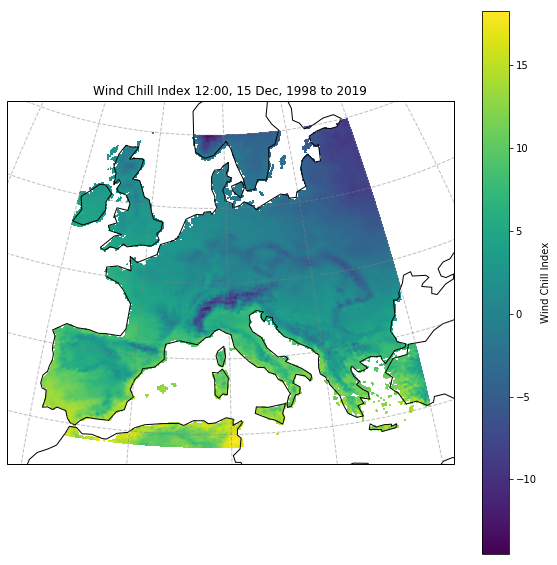

In [23]:
# create the figure panel 
fig = plt.figure(figsize=(10,10))
# create the map using the cartopy Orthographic projection
ax = plt.subplot(1,1,1, projection=ccrs.Orthographic(central_longitude=8., central_latitude=42.))
# add coastlines
ax.coastlines()
ax.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# provide a title
ax.set_title('Wind Chill Index 12:00, 15 Dec, 1998 to 2019')
# plot twc
im = plt.pcolormesh(twc_mean.longitude, twc_mean.latitude,
                    twc_mean, cmap='viridis', transform=ccrs.PlateCarree())
# add colourbar
cbar = plt.colorbar(im)
cbar.set_label('Wind Chill Index')

Can you identify areas where frostbite may occur (see chart below)?

<img src='./img/Windchill_effect_en.svg' align='left' width='60%'></img>

RicHard-59, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons

## <a id='era5'></a>4. Exercise: Repeat process with ERA5 data and compare results
So far you have plotted wind chill using the UERRA regional reanalysis dataset, but how accurate is this plot? One way to assess a dataset is to compare it with an alternative independent one to see what differences there may be. An alternative to UERRA is the ERA5 reanalysis data that you used in the previous tutorials. Repeat the steps above with ERA5 and compare your results with those obtained using UERRA.

<hr>